In [7]:
import os
import torch
from torch.utils.data import Dataset
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import cv2


In [9]:
from typing import Any, Tuple

In [20]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, target_transform : Any=None) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        self.data['label'] = self.data['label'].apply(lambda label: 0 if label == 'polarbear' else 1)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label


In [21]:
df = pd.read_csv('paths.csv', usecols = (0, 2), names = ('path_to_image', 'label'))

In [22]:
df['label'] = df['label'].apply(lambda label: 0 if label == 'polarbear' else 1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   path_to_image  2006 non-null   object
 1   label          2006 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.5+ KB


In [24]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [25]:
my_dataset = MyDataset('paths.csv', custom_transforms)

In [31]:
len(my_dataset)

2006

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


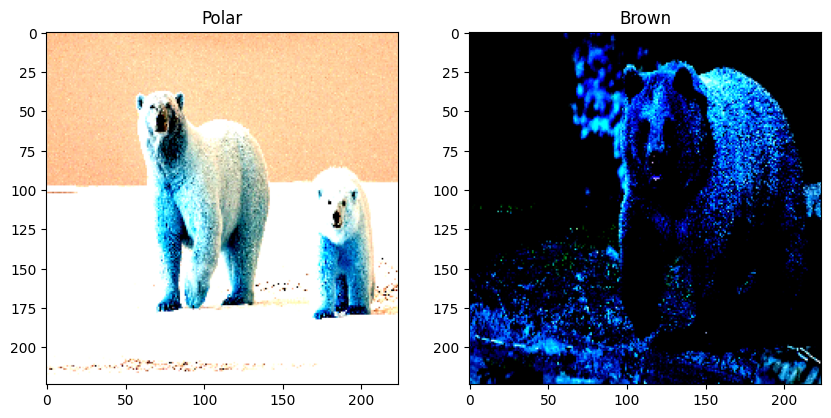

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Polar" if my_dataset[0][1] == 0 else "Brown")
plt.imshow(my_dataset[0][0].permute(1, 2, 0).numpy()[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.title("Polar" if my_dataset[1005][1] == 0 else "Brown")
plt.imshow(my_dataset[1005][0].permute(1, 2, 0).numpy()[:, :, ::-1])